# PhageHostLearn - v2.3 (Klebsiella)

An AI-based Phage-Host interaction predictor framework with K-loci and receptor-binding proteins at its core. This particular PhageHostLearn is for *Klebsiella pneumoniae* related phages. This notebook follows after having ran the PhageHostLearn_processing steps implemented in the accompanying Jupyter notebook.

**Architecture of this framework**: 
- Multi-RBP setting: phages consisting of one or more RBPs (multi-instance)
- K-loci proteins (multi-instance) 
- Embeddings for both that are concatenated
- Train an XGBoost model on the concatenated embeddings (binary classification)

**Overview of the notebook**:

1. [Transform the loci proteins into embeddings](#locusembed)
2. [Transform the RBP sequences into embeddings](#rbpembed)
3. Constructing a dataframe for training models
4. [Concatenate and train an XGBoost and RF models](#models)

## 0 - Libraries and directories

In [1]:
import os
import math
import json
#import umap
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
from Bio import SeqIO
from xgboost import XGBClassifier
from scipy.stats import spearmanr
from Bio.Blast import NCBIWWW, NCBIXML
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from Bio.Blast.Applications import NcbiblastpCommandline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, LeaveOneGroupOut
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, auc, precision_recall_curve,
#from bio_embeddings.embed import Word2VecEmbedder, ProtTransBertBFDEmbedder, SeqVecEmbedder
%matplotlib inline

In [2]:
# set project directory (to locate Kaptive), data directory and results directory
project_dir = '/Users/dimi/Documents/GitHub_Local/PhageHostLearning'
valencia_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data' # general directory
data_suffix = 'Valencia' # choose a suffix for the created data files
results_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models'
cdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228'

## 1 - Transform locus into embeddings<a name="locusembed"></a>

In [12]:
def loci_protein_embeddings(dict_path, results_dir):
    """
    This function computes ProtTransBertBFD embeddings for loci proteins in a dictionary (as json). It uses 
    the bio-embeddings package together with BioPython.
    
    WARNING: running this on a personal laptop without GPU can be slow (not advised). Best to start a Google
    Colab notebook and run the computations in the cloud.
    
    Input:
    - jason_dict: path to dictionary (json file) containing the accessions as keys and proteins as values
    - results_dir: path to dir to store embeddings
    Output:
    - an embeddings file with 1 resulting embedding per accession (= multi-instance)
    """
    
    # Load json file
    dict_file = open(dict_path)
    loci_dict = json.load(dict_file)
    
    # compute embeddings
    embedder = ProtTransBertBFDEmbedder()
    embeddings_list = [] # store locus embeddings
    for key in tqdm(loci_dict.keys()):
        embeddings = [embedder.reduce_per_protein(embedder.embed(sequence)) for sequence in tqdm(loci_dict[key])]
        locus_emb_matrix = np.vstack(embeddings)
        locus_embedding = np.mean(locus_emb_matrix, axis=0)
        embeddings_list.append(locus_embedding)
        
    embeddings_df = pd.concat([pd.DataFrame({'accession':list(loci_dict.keys())}), pd.DataFrame(embeddings_list)], axis=1)
    embeddings_df.to_csv(results_dir+'/loci_embeddings.csv', index=False)
    
    return

In [ ]:
#json_file = valencia_dir+'/LociBaseValencia.json'
#loci_protein_embeddings(json_file, '')

## 2 - Tranform RBP sequences into embeddings <a name="rbpembed"></a>

In [ ]:
def RBP_embeddings(RBPbase, results_dir):
    """
    This function computes embeddings for RBPs in a pandas dataframe.
    """
    embedder = ProtTransBertBFDEmbedder()
    embeddings = [embedder.reduce_per_protein(embedder.embed(sequence)) for sequence in tqdm(RBPbase['protein_sequence'])]
    embeddings_df = pd.concat([pd.DataFrame({'protein_ID':list(RBPbase['protein_ID'])}), pd.DataFrame(embeddings)], axis=1)
    embeddings_df.to_csv(results_dir+'/RBP_embeddings.csv', index=False)
    return

In [65]:
#RBPbase = pd.read_csv(valencia_dir+'/RBPbase'+data_suffix+'.csv')
#RBP_embeddings(RBPbase, results_dir) # do in Google Colab or Kaggle

Alternatively, we can subselect previously computed embeddings (for RBP detection step)

In [18]:
phage_protein_embeddings = pd.read_csv(valencia_dir+'/phage_proteinsValencia_embeddings.csv')
RBPbase = pd.read_csv(valencia_dir+'/RBPbase'+data_suffix+'.csv')

to_delete = []
for i, protein_id in enumerate(phage_protein_embeddings['ID']):
    if protein_id not in list(RBPbase['protein_ID']):
        to_delete.append(i)
        
RBP_embeddings = phage_protein_embeddings.drop(to_delete)
RBP_embeddings = RBP_embeddings.reset_index(drop=True)
RBP_embeddings = pd.concat([RBPbase['phage_ID'], RBP_embeddings], axis=1)
RBP_embeddings.to_csv(valencia_dir+'/RBP_embeddings.csv', index=False)

## 3 - Processing into structured dataframe for training at multi-RBP level

In [3]:
# construct multi-RBP representations
RBP_embeddings = pd.read_csv(valencia_dir+'/RBP_embeddings.csv')

multi_embeddings = []
names = []
for phage_id in list(set(RBP_embeddings['phage_ID'])):
    rbp_embeddings = RBP_embeddings.iloc[:,2:][RBP_embeddings['phage_ID'] == phage_id]
    multi_embedding = np.mean(np.asarray(rbp_embeddings), axis=0)
    names.append(phage_id)
    multi_embeddings.append(multi_embedding)
multiRBP_embeddings = pd.concat([pd.DataFrame({'phage_ID': names}), pd.DataFrame(multi_embeddings)], axis=1)

In [4]:
# construct dataframe for training
loci_embeddings = pd.read_csv(valencia_dir+'/loci_embeddings.csv')
interactions = pd.read_csv(valencia_dir+'/phage_host_interactionsValencia.csv', index_col=0)
features = []
labels = []
groups_loci = []
groups_phage = []
for i, accession in enumerate(loci_embeddings['accession']):
    for j, phage_id in enumerate(multiRBP_embeddings['phage_ID']):
        interaction = interactions.loc[accession][phage_id]
        if math.isnan(interaction) == False: # if the interaction is known
            features.append(pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]]))
            labels.append(int(interaction))
            groups_loci.append(i)
            groups_phage.append(j)
features = np.asarray(features)
print("Dimensions match?", features.shape[1] == (loci_embeddings.shape[1]+multiRBP_embeddings.shape[1]-2))

Dimensions match? True


## 4 - Building and evaluating machine learning models <a name="models"></a>

Idea is to (1) shuffle data, (2) keep a test set aside, (3) do CV for hyperparameter tuning, (4) plot learning curves with optimized hyperparams and (5) test final performance on test set.

#### XGBoost

In [14]:
# shuffle and set test set aside
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)

In [6]:
# define model and cross-validation iterator
cpus = 6
imbalance = sum([1 for i in y_train if i ==1]) / sum([1 for i in y_train if i ==0])
xgb = XGBClassifier(scale_pos_weight=1/imbalance, n_jobs=cpus, use_label_encoder=False)
params_xgb = {'max_depth': [3, 5, 7], 'n_estimators': [100, 250, 500, 750], 
              'learning_rate': [0.1, 0.2, 0.3]}
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [58]:
# do hyperparameter tuning (in GridSearchCV)
tuned_xgb = GridSearchCV(xgb, cv=cv, param_grid=params_xgb, scoring='roc_auc', verbose=3)
tuned_xgb.fit(X_train, y_train, eval_metric='logloss')
print(tuned_xgb.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END learning_rate=0.05, max_depth=1, n_estimators=50;, score=0.752 total time=   2.0s
[CV 2/5] END learning_rate=0.05, max_depth=1, n_estimators=50;, score=0.793 total time=   1.9s
[CV 3/5] END learning_rate=0.05, max_depth=1, n_estimators=50;, score=0.744 total time=   1.9s
[CV 4/5] END learning_rate=0.05, max_depth=1, n_estimators=50;, score=0.739 total time=   2.0s
[CV 5/5] END learning_rate=0.05, max_depth=1, n_estimators=50;, score=0.733 total time=   2.0s
[CV 1/5] END learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.789 total time=   3.1s
[CV 2/5] END learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.826 total time=   3.1s
[CV 3/5] END learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.757 total time=   3.1s
[CV 4/5] END learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.743 total time=   3.1s
[CV 5/5] END learning_rate=0.05, max_depth=1, n_estimators=100;, score=0.750 to

[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=250;, score=0.838 total time=   8.9s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=250;, score=0.765 total time=   8.8s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=250;, score=0.735 total time=   8.8s
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=250;, score=0.775 total time=   8.9s
[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=500;, score=0.774 total time=  16.6s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=500;, score=0.829 total time=  17.5s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=500;, score=0.762 total time=  17.7s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=500;, score=0.731 total time=  16.8s
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=500;, score=0.775 total time=  16.7s
[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=750;, score=0.763 total time=  24.6s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_est

[CV 4/5] END learning_rate=0.2, max_depth=1, n_estimators=750;, score=0.727 total time=  24.8s
[CV 5/5] END learning_rate=0.2, max_depth=1, n_estimators=750;, score=0.768 total time=  24.7s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=50;, score=0.856 total time=   5.2s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=50;, score=0.868 total time=   5.3s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=50;, score=0.824 total time=   5.3s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=50;, score=0.761 total time=   5.3s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=50;, score=0.841 total time=   5.3s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.862 total time=   9.4s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.872 total time=   9.4s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.822 total time=   9.4s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimato

[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=250;, score=0.887 total time=  20.0s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=250;, score=0.891 total time=  20.1s
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=250;, score=0.824 total time=  20.0s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=250;, score=0.792 total time=  20.0s
[CV 5/5] END learning_rate=0.3, max_depth=3, n_estimators=250;, score=0.883 total time=  20.0s
[CV 1/5] END learning_rate=0.3, max_depth=3, n_estimators=500;, score=0.890 total time=  39.1s
[CV 2/5] END learning_rate=0.3, max_depth=3, n_estimators=500;, score=0.891 total time=  39.0s
[CV 3/5] END learning_rate=0.3, max_depth=3, n_estimators=500;, score=0.827 total time=  39.1s
[CV 4/5] END learning_rate=0.3, max_depth=3, n_estimators=500;, score=0.794 total time=  39.1s
[CV 5/5] END learning_rate=0.3, max_depth=3, n_estimators=500;, score=0.883 total time=  39.3s
[CV 1/5] END learning_rate=0.3, max_depth=3, n_est

[0]	validation_0-auc:0.90894	validation_1-auc:0.75502
[1]	validation_0-auc:0.93474	validation_1-auc:0.73120
[2]	validation_0-auc:0.95118	validation_1-auc:0.75912
[3]	validation_0-auc:0.95917	validation_1-auc:0.74978
[4]	validation_0-auc:0.96077	validation_1-auc:0.76022
[5]	validation_0-auc:0.96709	validation_1-auc:0.74988
[6]	validation_0-auc:0.97447	validation_1-auc:0.75753
[7]	validation_0-auc:0.97929	validation_1-auc:0.75451
[8]	validation_0-auc:0.98265	validation_1-auc:0.75569
[9]	validation_0-auc:0.98462	validation_1-auc:0.74224
[10]	validation_0-auc:0.98565	validation_1-auc:0.74474
[11]	validation_0-auc:0.98810	validation_1-auc:0.75127
[12]	validation_0-auc:0.98952	validation_1-auc:0.74273
[13]	validation_0-auc:0.98989	validation_1-auc:0.73826
[14]	validation_0-auc:0.99012	validation_1-auc:0.73635
[15]	validation_0-auc:0.99067	validation_1-auc:0.74488
[16]	validation_0-auc:0.99089	validation_1-auc:0.74326
[17]	validation_0-auc:0.99178	validation_1-auc:0.74827
[18]	validation_0-au

[149]	validation_0-auc:0.99972	validation_1-auc:0.75535
[150]	validation_0-auc:0.99972	validation_1-auc:0.75492
[151]	validation_0-auc:0.99972	validation_1-auc:0.75444
[152]	validation_0-auc:0.99972	validation_1-auc:0.75432
[153]	validation_0-auc:0.99972	validation_1-auc:0.75417
[154]	validation_0-auc:0.99972	validation_1-auc:0.75311
[155]	validation_0-auc:0.99972	validation_1-auc:0.75343
[156]	validation_0-auc:0.99972	validation_1-auc:0.75287
[157]	validation_0-auc:0.99972	validation_1-auc:0.75347
[158]	validation_0-auc:0.99972	validation_1-auc:0.75349
[159]	validation_0-auc:0.99972	validation_1-auc:0.75362
[160]	validation_0-auc:0.99972	validation_1-auc:0.75283
[161]	validation_0-auc:0.99972	validation_1-auc:0.75318
[162]	validation_0-auc:0.99972	validation_1-auc:0.75357
[163]	validation_0-auc:0.99972	validation_1-auc:0.75241
[164]	validation_0-auc:0.99972	validation_1-auc:0.75226
[165]	validation_0-auc:0.99972	validation_1-auc:0.75357
[166]	validation_0-auc:0.99972	validation_1-auc:

[296]	validation_0-auc:0.99972	validation_1-auc:0.75108
[297]	validation_0-auc:0.99972	validation_1-auc:0.75129
[298]	validation_0-auc:0.99972	validation_1-auc:0.75146
[299]	validation_0-auc:0.99972	validation_1-auc:0.75165
[300]	validation_0-auc:0.99972	validation_1-auc:0.75148
[301]	validation_0-auc:0.99972	validation_1-auc:0.75154
[302]	validation_0-auc:0.99972	validation_1-auc:0.75116
[303]	validation_0-auc:0.99972	validation_1-auc:0.75137
[304]	validation_0-auc:0.99972	validation_1-auc:0.75094
[305]	validation_0-auc:0.99972	validation_1-auc:0.75126
[306]	validation_0-auc:0.99972	validation_1-auc:0.75112
[307]	validation_0-auc:0.99972	validation_1-auc:0.75089
[308]	validation_0-auc:0.99972	validation_1-auc:0.75102
[309]	validation_0-auc:0.99972	validation_1-auc:0.75154
[310]	validation_0-auc:0.99972	validation_1-auc:0.75145
[311]	validation_0-auc:0.99972	validation_1-auc:0.75154
[312]	validation_0-auc:0.99972	validation_1-auc:0.75121
[313]	validation_0-auc:0.99972	validation_1-auc:

[443]	validation_0-auc:0.99972	validation_1-auc:0.75035
[444]	validation_0-auc:0.99972	validation_1-auc:0.75059
[445]	validation_0-auc:0.99972	validation_1-auc:0.75062
[446]	validation_0-auc:0.99972	validation_1-auc:0.75069
[447]	validation_0-auc:0.99972	validation_1-auc:0.75065
[448]	validation_0-auc:0.99972	validation_1-auc:0.75059
[449]	validation_0-auc:0.99972	validation_1-auc:0.75047
[450]	validation_0-auc:0.99972	validation_1-auc:0.75036
[451]	validation_0-auc:0.99972	validation_1-auc:0.75043
[452]	validation_0-auc:0.99972	validation_1-auc:0.75023
[453]	validation_0-auc:0.99972	validation_1-auc:0.75020
[454]	validation_0-auc:0.99972	validation_1-auc:0.75036
[455]	validation_0-auc:0.99972	validation_1-auc:0.75034
[456]	validation_0-auc:0.99972	validation_1-auc:0.75054
[457]	validation_0-auc:0.99972	validation_1-auc:0.75071
[458]	validation_0-auc:0.99972	validation_1-auc:0.75069
[459]	validation_0-auc:0.99972	validation_1-auc:0.75085
[460]	validation_0-auc:0.99972	validation_1-auc:

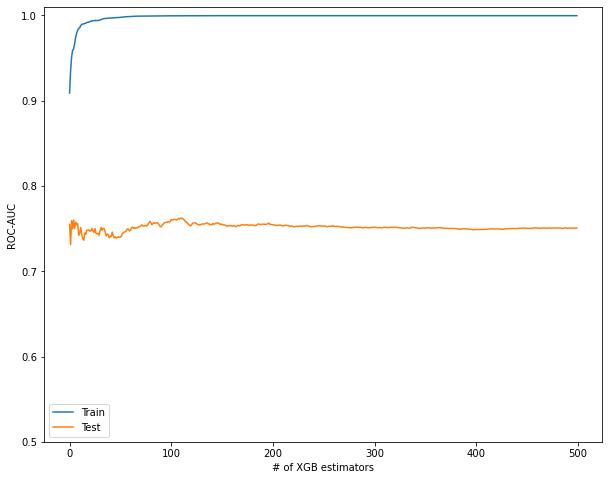

In [59]:
# fit optimized model and plot learning curves
xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.2, n_estimators=500, max_depth=5,
                    n_jobs=cpus, use_label_encoder=False)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
eval_set = [(X_tr, y_tr), (X_val, y_val)]
xgb.fit(X_tr, y_tr, eval_metric='auc', eval_set=eval_set)
results = xgb.evals_result()
epochs = len(results['validation_0']['auc'])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(range(0, epochs), results['validation_0']['auc'], label='Train')
ax.plot(range(0, epochs), results['validation_1']['auc'], label='Test')
ax.legend()
ax.set_ylabel('ROC-AUC')
ax.set_xlabel('# of XGB estimators')
ax.set_ylim(0.5, 1.01)
fig.savefig(results_dir+'/models/v22_multi_language_learning_curve.png', dpi=400)

In [15]:
# test set evaluation
xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.2, n_estimators=500, max_depth=5,
                    n_jobs=cpus, use_label_encoder=False)
xgb.fit(X_train, y_train)
score_xgb = xgb.predict_proba(X_test)[:,1]
print('AUC:', roc_auc_score(y_test, score_xgb))

[11:17:37] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.9223658933693994


In [18]:
results = pd.DataFrame({'labels': y_test, 'scores': score_xgb})
results.to_csv(results_dir+'/v2.2/language_xgb_scores.csv', index=False)

The fact that we're seeing a higher AUC on the test set then before with the learning curve to me indicates that sufficient data is crucial! In the learning curve, we splitted X_train up into train an validation, and result is lower AUC... so enough data seems crucial!

#### Randomized labels

In [17]:
random.shuffle(y_train)
xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.2, n_estimators=500, max_depth=5,
                    n_jobs=cpus, use_label_encoder=False)
xgb.fit(X_train, y_train)
score_xgb = xgb.predict_proba(X_test)[:,1]
print('AUC:', roc_auc_score(y_test, score_xgb))
results = pd.DataFrame({'labels': y_test, 'scores': score_xgb})
results.to_csv(results_dir+'/v2.2/language_xgb_scores_random.csv', index=False)

[11:21:38] WARNING: /private/var/folders/p1/fvz7cyr12yl0lf647b14byy80000gn/T/pip-install-w5n3w6k9/xgboost_a8a36401f804426fb00f941f2eae565c/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC: 0.5167767890216484


#### LOGOCV XGBoost over loci

Basically, the idea is to do a LOGOCV with every locus being one group (so a total of ~200 groups). We won't do hyperparam optimization, as that would be too computationally intensive, but we will assume standard params except for the 500 estimators. Then, we can also compute MRR, because we know that each test set is in fact one query for which the probabilities can be ranked.

In [5]:
seros = pd.read_csv(valencia_dir+'/serotypes'+data_suffix+'.csv')

In [6]:
def mean_reciprocal_rank(queries):
    """
    This function computes the mean reciprocal rank for a given array or
    matrix of queries. It deals with relevant vs. non-relevant queries that are
    binary. If queries is a matrix, then it will compute the reciprocal ranks over
    all rows individually (for each 'query') and then average those.
    E.g.:
    queries = [[0, 0, 0], [0, 1, 0], [1, 0, 0]]
    mean_reciprocal_rank(queries) -> 0.5
    """
    queries = (np.asarray(r).nonzero()[0] for r in queries)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in queries])

In [ ]:
# do the LOGOCV
logo = LeaveOneGroupOut()
cpus = 6
rocauc_scores = []
prauc_scores = []
noauc_scores = []
ranked_queries = []
labels = np.asarray(labels)
sero_groups = []
pbar = tqdm(total=200)
for train_index, test_index in logo.split(features, labels, groups_loci):
    # get the training and test data
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    imbalance = sum([1 for i in y_train if i ==1]) / sum([1 for i in y_train if i ==0])

    # fit a XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, n_estimators=500, n_jobs=cpus, eval_metric='logloss', 
                        use_label_encoder=False)
    xgb.fit(X_train, y_train)
    
    # make predictions & compute ROC + PR AUC
    score_xgb = xgb.predict_proba(X_test)[:,1]
    try:
        precision, recall, thresholds = precision_recall_curve(y_test, score_xgb)
        pr_auc = round(auc(recall, precision), 3)
        roc_auc = roc_auc_score(y_test, score_xgb)
        rocauc_scores.append(roc_auc)
        prauc_scores.append(pr_auc)
        this_sero = seros['sero'][groups_loci[test_index[0]]]
        sero_groups.append(this_sero) # get serotype linked to this test group
        # sort labels to compute MRR later
        ranked_query = [x for _, x in sorted(zip(score_xgb, y_test), reverse=True)]
        ranked_queries.append(ranked_query)
    except:
        noauc_scores.append(score_xgb)
  
    # pbar update
    pbar.update(1)
pbar.close()

In [8]:
# print results
print('ROC AUC: ', np.mean(rocauc_scores))
print('PR AUC: ', np.mean(prauc_scores))
print('MRR: ', mean_reciprocal_rank(ranked_queries))
logo_results = pd.DataFrame({'sero': sero_groups, 'rocauc_scores': rocauc_scores, 'prauc_scores': prauc_scores, 
                             'ranked_queries': ranked_queries})
logo_results.to_csv(results_dir+'/v2.3/language_xgb_logocv_results.csv', index=False)

AUC:  0.7934344392405449
MRR:  0.6516745268978681


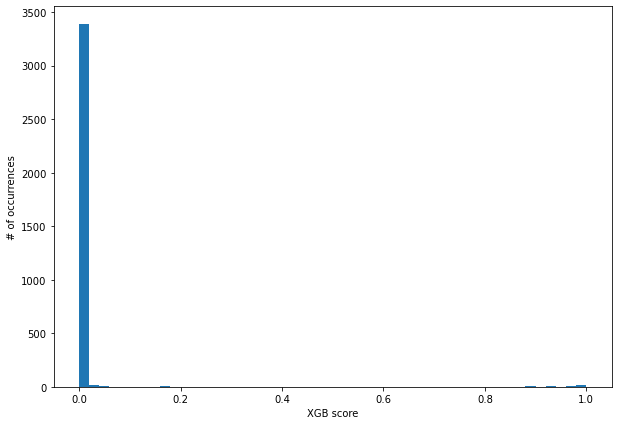

In [19]:
noauc_flat = np.concatenate(noauc_scores).ravel()
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(noauc_flat, bins=50)
ax.set_xlabel('XGB score')
ax.set_ylabel('# of occurrences')
fig.savefig(results_dir+'/v2.3/language_xgb_logocv_noauc_scores.png', dpi=400)

#### Single-RBP LOOCV

In [80]:
logo = LeaveOneGroupOut()
cpus = 6
rocauc_scores = []
prauc_scores = []
noauc_scores = []
ranked_queries = []
labels = np.asarray(labels)
sero_groups = []
pbar = tqdm(total=200)
for train_index, test_index in logo.split(features, labels, groups_loci):
    # get the training and test data
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    phage_test = np.asarray(groups_phage)[test_index]
    imbalance = sum([1 for i in y_train if i ==1]) / sum([1 for i in y_train if i ==0])

    # fit a XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, n_estimators=500, n_jobs=cpus, eval_metric='logloss', 
                        use_label_encoder=False)
    xgb.fit(X_train, y_train)
    
    # loop over phage's RBPs
    score_xgb = []
    loci_embedding = X_test[0, :1024] # always the same within a test group
    # enumerate can go if test works out, just same loci embedding all over
    for phage_index in phage_test:
        # get the correct embeddings
        phage_id = list(multiRBP_embeddings['phage_ID'])[phage_index]
        rbp_embeddings = RBP_embeddings.iloc[:,2:][RBP_embeddings['phage_ID'] == phage_id]
        
        # make predictions for each single RBP
        rbp_scores = []
        for rbpi in range(rbp_embeddings.shape[0]):
            test_embedding = pd.concat([pd.DataFrame(loci_embedding), rbp_embeddings.iloc[rbpi,:]])
            this_xgb_score = xgb.predict_proba(np.asarray(test_embedding).reshape((1,-1)))[:,1]
            rbp_scores.append(this_xgb_score[0])
                              
        # add max score to the list for AUC computing
        score_xgb.append(max(rbp_scores))
    
    # compute ROC & PR AUC
    try:
        precision, recall, thresholds = precision_recall_curve(y_test, score_xgb)
        pr_auc = round(auc(recall, precision), 3)
        roc_auc = roc_auc_score(y_test, score_xgb)
        rocauc_scores.append(roc_auc)
        prauc_scores.append(pr_auc)
        this_sero = seros['sero'][groups_loci[test_index[0]]]
        sero_groups.append(this_sero) # get serotype linked to this test group
        print(this_sero, this_auc)

        # sort labels to compute MRR later
        ranked_query = [x for _, x in sorted(zip(score_xgb, y_test), reverse=True)]
        ranked_queries.append(ranked_query) 
    except:
        noauc_scores.append(score_xgb)

    # pbar update
    pbar.update(1)
pbar.close()

  0%|          | 0/200 [00:00<?, ?it/s]

K41 0.9454545454545453
K15 0.5636363636363637
K14 0.7647058823529411
K43 0.7358490566037736
K74 0.28703703703703703
K62 0.5098039215686274
K18 0.6805555555555556
K74 0.7454545454545455
K25 0.7636363636363637
K46 0.4545454545454546
K2 0.3090909090909091
K68 0.8133333333333332
K11 0.8499999999999999
K51 0.0
K34 0.9636363636363636
K36 0.87
K29 0.9666666666666668
K39 0.7685185185185185
K31 0.787037037037037
K61 0.42592592592592593
K8 0.6153846153846153
K80 0.7454545454545455
K26 0.7861635220125787
K47 0.8727272727272728
K58 0.610062893081761
K30 0.5786163522012578
K32 0.9119496855345912
K60 0.6289308176100629
K63 0.509090909090909
K55 0.7766666666666666
K13 0.7215686274509804
K16 0.8101851851851852
K59 0.7090909090909091
K6 0.0
K64 0.9466666666666667
K65 0.9294117647058824
K12 0.5454545454545455
K49 0.5648148148148149
K66 0.19999999999999996
K35 0.7895981087470448
K33 0.7672955974842768
K9 0.38181818181818183
K38 0.4807692307692308
K50 0.8333333333333334
K3 0.3392156862745099
K17 0.4722222

In [81]:
# print results
print('ROC AUC: ', np.mean(rocauc_scores))
print('PR AUC: ', np.mean(prauc_scores))
print('MRR: ', mean_reciprocal_rank(ranked_queries))
logo_results = pd.DataFrame({'sero': sero_groups, 'rocauc_scores': rocauc_scores, 'prauc_scores': prauc_scores, 
                             'ranked_queries': ranked_queries})
logo_results.to_csv(results_dir+'/v2.3/language_xgb_singlerbp_logocv_results.csv', index=False)

AUC:  0.7616145491774577
MRR:  0.43329340490851914


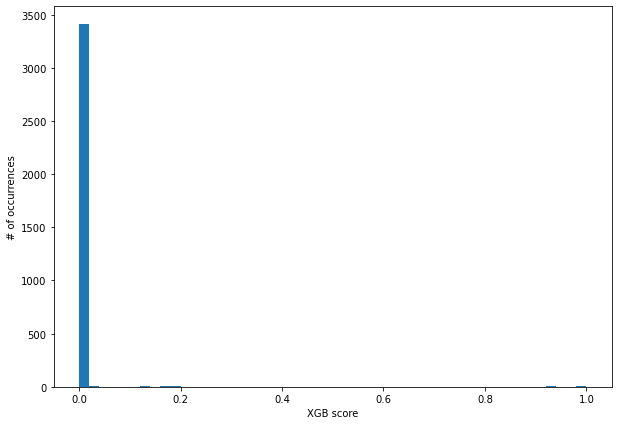

In [82]:
noauc_flat = np.concatenate(noauc_scores).ravel()
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(noauc_flat, bins=50)
ax.set_xlabel('XGB score')
ax.set_ylabel('# of occurrences')
fig.savefig(results_dir+'/v2.3/language_xgb_singlerbp_logocv_noauc_scores.png', dpi=400)

## X - Out of use